# 📊 Feature Engineering for Time Series with Missing Values
This notebook demonstrates a feature engineering (FE) pipeline for time series data with missing values, using Python and pandas.

We simulate data, introduce missing values, apply FE steps, and visualize each part.

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [21]:
from statistics import LinearRegression
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA



In [22]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

C:\Users\thanh\AppData\Local\Temp\ipykernel_25996\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_25996\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_25996\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_25996\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31

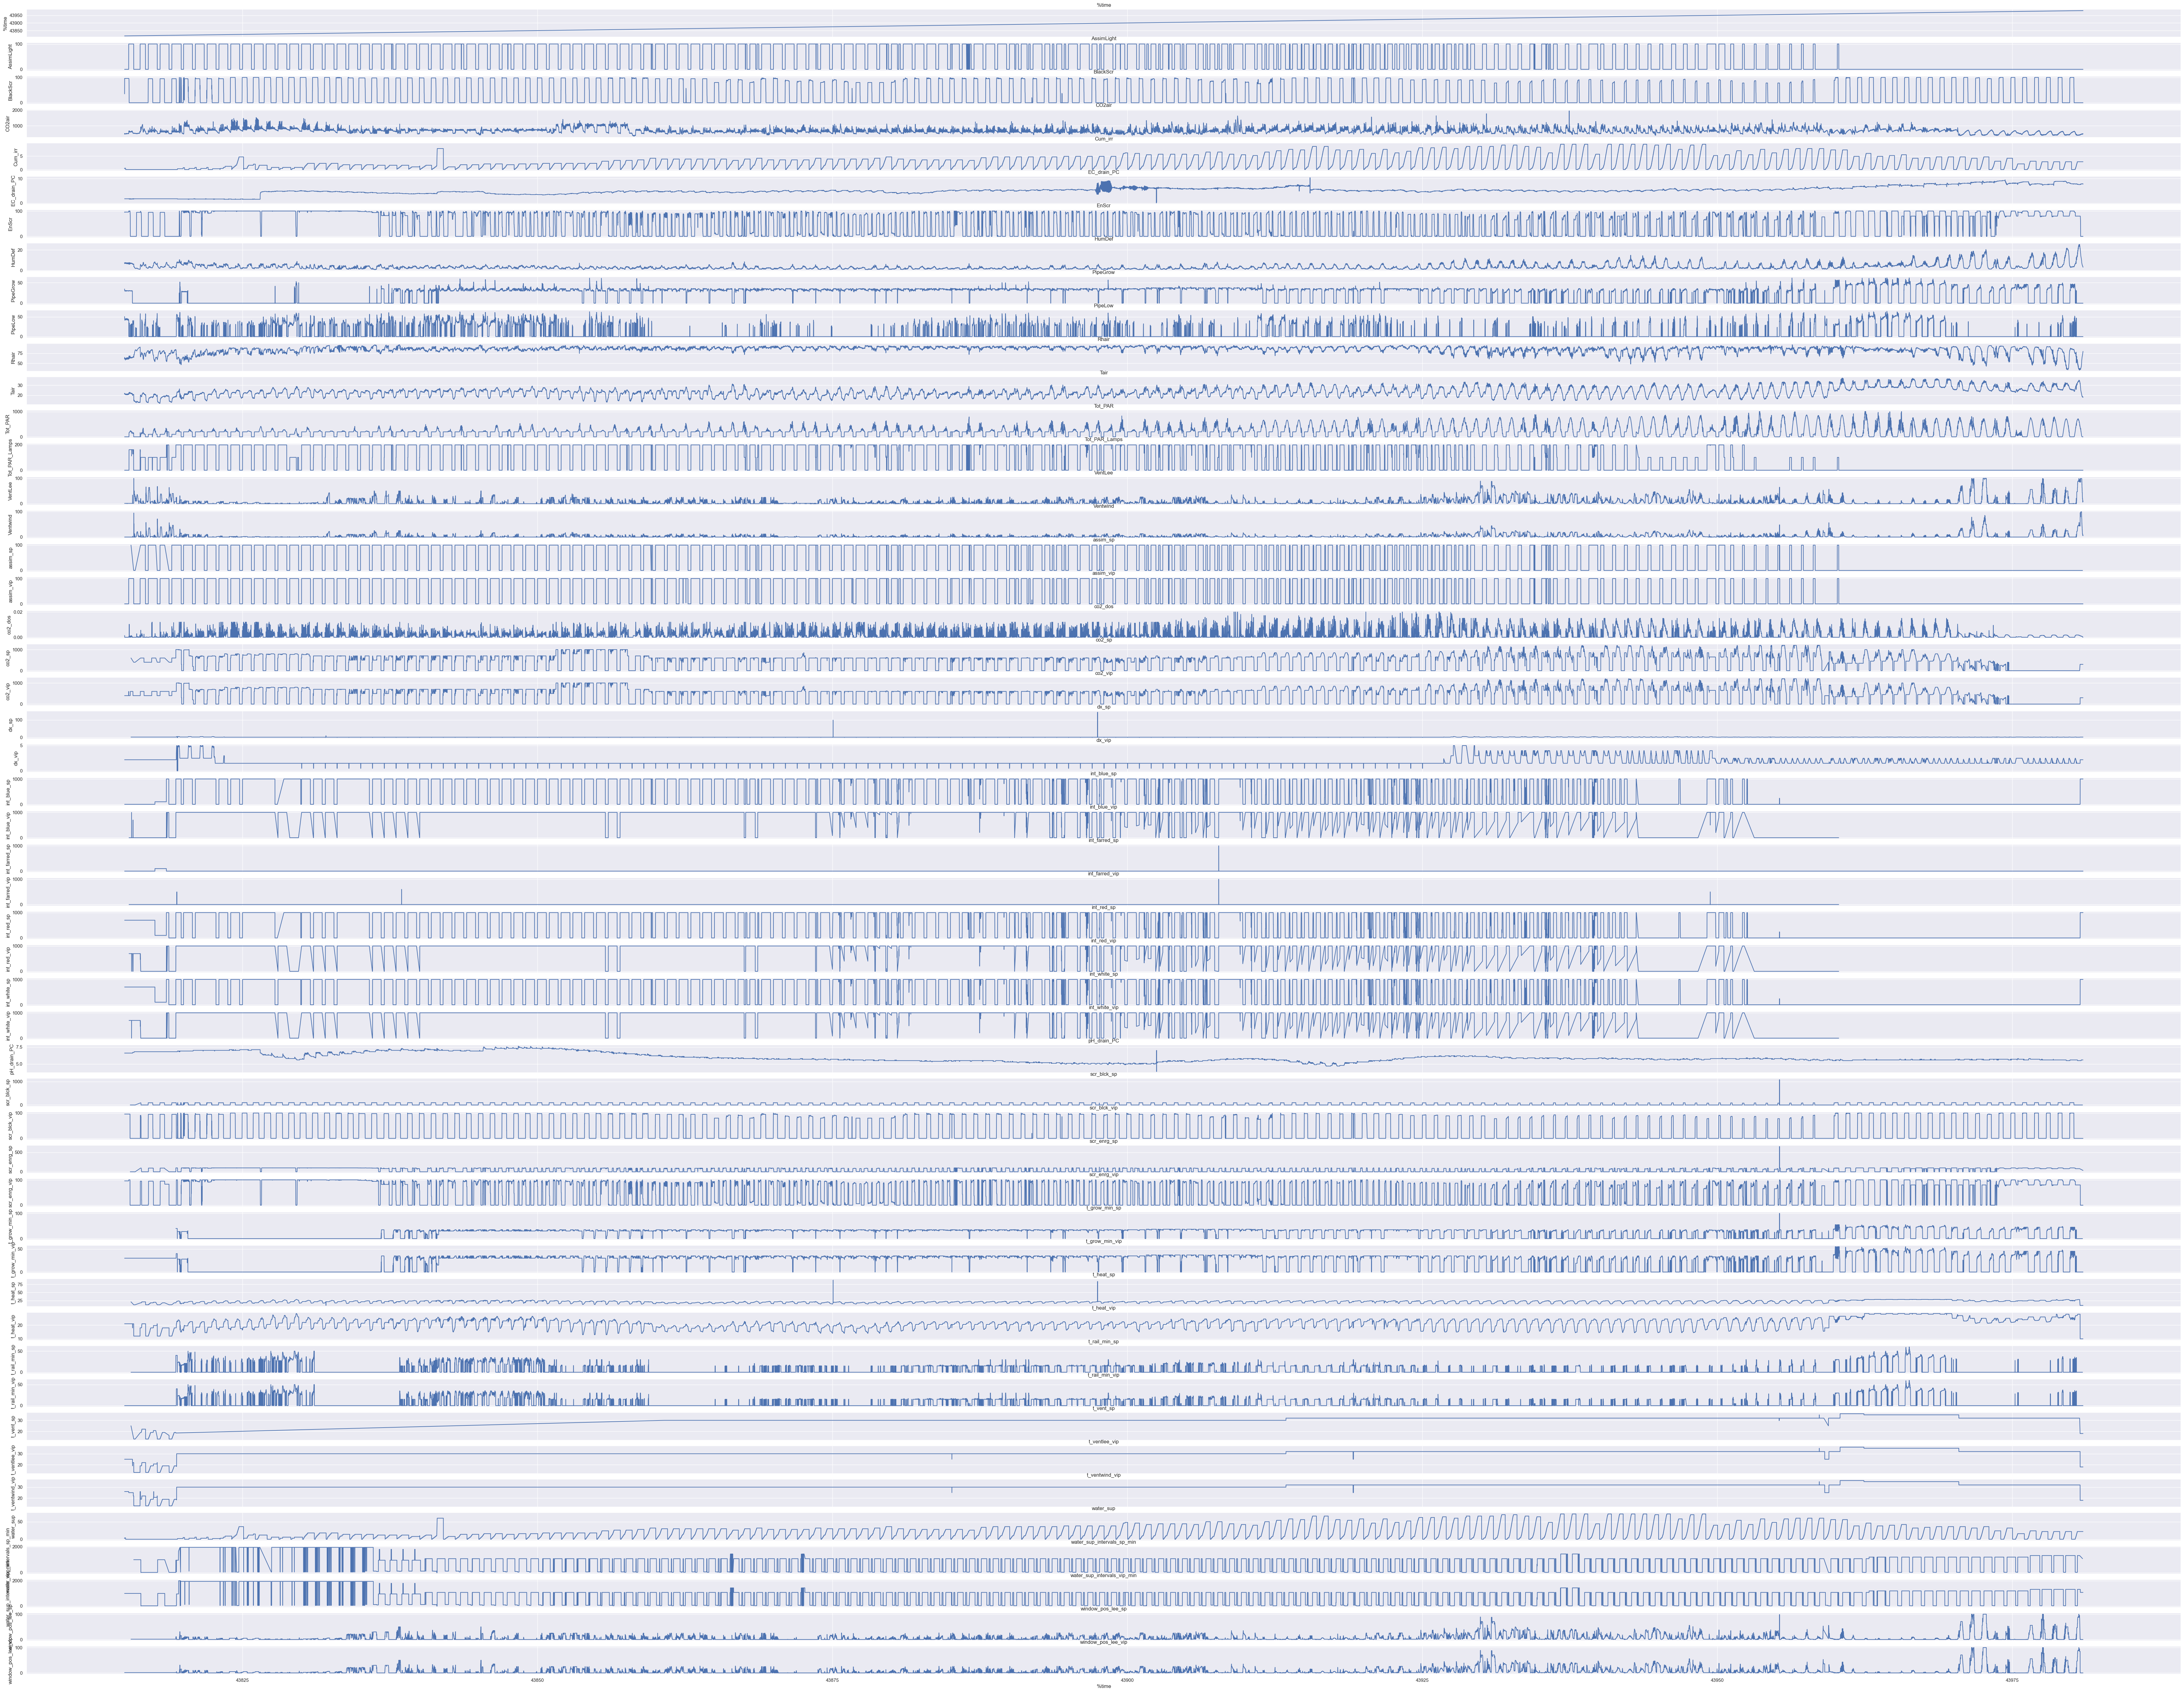

In [23]:
import seaborn as sns
sns.set_theme(style="darkgrid")
def plot_feature(df):
    features_df = df["GreenhouseClimate.csv"]
    fig, axes = plt.subplots(nrows = 50 , ncols = 1, figsize=(90,70), sharex= True)
    for i, column in enumerate(features_df.columns):
            sns.lineplot(x="%time", y=column, data=features_df, ax=axes[i])
            axes[i].set_title(column)
plot_feature(ds["Automatoes"])

#### Handle missing data

In [24]:
def knn_mean(ts, n=4):
    ts = np.array(ts)
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            lower = max(0, i - n)
            upper = min(len(ts), i + n + 1)
            neighbors = ts[lower:i].tolist() + ts[i+1:upper].tolist()
            neighbors = [x for x in neighbors if not np.isnan(x)]
            out[i] = np.mean(neighbors) if neighbors else np.nan
    return out

def handle_missing_values(df):
    imputations ={}
    missing_percent = df.isnull().mean() # .mean() will return the % null value
    df_filtered = df.loc[:, missing_percent<0.2] # filtered all the features with %null> 20%
    print('Percentage of Null value after filtered: ')
    print(df_filtered.isnull().mean())
    imputations.update({
        'backward/forward_fill': df_filtered.bfill().ffill()
    })

    knn_imputer = KNNImputer(n_neighbors=5)
    
    df_knn_imputed = pd.DataFrame(
        knn_imputer.fit_transform(df_filtered), 
        columns=df_filtered.columns, 
        index=df_filtered.index  
    )
    
    imputations['knn_imputer'] = df_knn_imputed
    print("\n🧮 Null Value Count After Each Imputation:")
    for method_name, df_imputed in imputations.items():
        total_nulls = df_imputed.isnull().sum().sum()
        print(f"{method_name}: {total_nulls} missing values remaining")
        
    return imputations

#### Convert time from excel format to datetime

In [25]:
from datetime import datetime, timedelta
def excel_to_datetime(excel_time):
    excel_epoch = datetime(1899, 12, 30)
    if excel_time < 61:
        excel_epoch = datetime(1899, 12, 31)
    return excel_epoch + timedelta(days=excel_time)

for name in dsLists:
    for key, df in ds[name].items():
        df.columns = df.columns.str.strip()
        if "%time" in df.columns:
            df["%time"] = df["%time"].apply(excel_to_datetime)
            df.set_index("%time", inplace=True)
        if "%Time" in df.columns:
            df.rename(columns={"%Time":"%time"}, inplace=True)
            df["%time"] = df["%time"].apply(excel_to_datetime)
            df.set_index("%time", inplace=True)


In [26]:
ds["Automatoes"]["Resources.csv"].head(5) # Test to see if the time conversion works

Heat_cons  ElecHigh  ElecLow  CO2_cons       Irr  Drain
%time                                                              
2019-12-16     2.1363       1.1  0.00000  0.006723  0.000000    0.0
2019-12-17     0.7203       0.8  0.00000  0.011022  0.000000    0.0
2019-12-18     0.6036       0.9  0.54000  0.012758  0.000000    0.0
2019-12-19     0.0000       1.1  0.54000  0.017378  0.000000    0.0
2019-12-20     1.4925       1.6  0.54675  0.051374  0.437273    0.0

#### Extract time based features

In [27]:
def extract_basic_time_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

#### Extract window features


In [28]:
def extract_window_features(df, sensor_cols):
    for col in sensor_cols:
        df[f'{col}_rolling_6h_mean'] = df[col].rolling('6h').mean()
        df[f'{col}_rolling_12h_std'] = df[col].rolling('12h').std()
        df[f'{col}_ewm'] = df[col].ewm(span=12).mean()
    return df

#### Select feature with tsfresh


In [29]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.feature_selection import mutual_info_regression

#### Reduce dimensions


#### Combine to a framework

In [30]:
features = ["VentLee","Ventwind","AssimLight","EnScr","BlackScr","assim_vip","scr_enrg_vip","scr_blck_vip","int_blue_vip","int_red_vip","int_farred_vip","int_white_vip"]
df_original = ds["Automatoes"]["GreenhouseClimate.csv"][features].copy()

df_target = ds["Automatoes"]["Resources.csv"]["ElecHigh"].copy()

print(f'Number of features before engineering: {len(df_original.columns)}')
imputed_df = handle_missing_values(df_original)

raw_df = imputed_df["knn_imputer"]

resampled_df = raw_df.resample('10T').agg(['mean'])
# df_engineered = extract_basic_time_features(resampled_df)    
df_engineered = resampled_df.copy()
# print(df_target.head(5))
df_engineered.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_engineered.columns]


df_engineered['date'] = df_engineered.index.date
df_engineered['time'] = df_engineered.index.time
print("\n--- Đang tạo Lag Features ---")

# Liệt kê các cột features gốc của bạn
df_wide = df_engineered.pivot_table(
    index='date',
    columns='time',
    values=df_engineered.columns
)

print("\n--- Dữ liệu sau khi pivot (cột có MultiIndex) ---")
print(df_wide)

# Xóa các dòng có giá trị NaN sau khi tạo lag
df_engineered.dropna(inplace=True)

print("\n--- Dữ liệu sau khi tạo Lag Features (5 dòng đầu) ---")
print(df_engineered.head())

# print(f'Number of features after engineering: {len(df_full.columns)}')
# print(df_full.head(5))


Number of features before engineering: 12
Percentage of Null value after filtered: 
VentLee         0.001485
Ventwind        0.001485
AssimLight      0.001485
EnScr           0.001485
BlackScr        0.001485
assim_vip       0.001485
scr_enrg_vip    0.001485
scr_blck_vip    0.001485
dtype: float64

🧮 Null Value Count After Each Imputation:
backward/forward_fill: 0 missing values remaining
knn_imputer: 0 missing values remaining

--- Đang tạo Lag Features ---

--- Dữ liệu sau khi pivot (cột có MultiIndex) ---
           AssimLight_mean                                               \
time              00:00:00 00:10:00 00:20:00 00:30:00 00:40:00 00:50:00   
date                                                                      
2019-12-16        0.000000      0.0      0.0      0.0      0.0      0.0   
2019-12-17        0.000000      0.0      0.0      0.0      0.0      0.0   
2019-12-18        0.000000      0.0    100.0    100.0    100.0    100.0   
2019-12-19        0.000000      0.0 

C:\Users\thanh\AppData\Local\Temp\ipykernel_25996\57787422.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_df = raw_df.resample('10T').agg(['mean'])


In [31]:
df_wide_flat = df_wide.copy() # Tạo bản sao để làm việc

# Sử dụng list comprehension để nối các cấp của MultiIndex thành một tên duy nhất
df_wide_flat.columns = [f"{feature}_{str(time)}" for feature, time in df_wide_flat.columns]

# print("\n\n--- 2. Dạng cột đã được làm phẳng (SẴN SÀNG cho model) ---")
# print(df_wide_flat.columns)
# print("\nDataFrame với cột đã được làm phẳng (5 dòng đầu):")
# print(df_wide_flat.head())

df_full = df_target.to_frame().join(df_wide_flat)
print(df_full.head())

            ElecHigh  AssimLight_mean_00:00:00  AssimLight_mean_00:10:00  \
%time                                                                      
2019-12-16       1.1                       0.0                       0.0   
2019-12-17       0.8                       0.0                       0.0   
2019-12-18       0.9                       0.0                       0.0   
2019-12-19       1.1                       0.0                       0.0   
2019-12-20       1.6                       0.0                     100.0   

            AssimLight_mean_00:20:00  AssimLight_mean_00:30:00  \
%time                                                            
2019-12-16                       0.0                       0.0   
2019-12-17                       0.0                       0.0   
2019-12-18                     100.0                     100.0   
2019-12-19                     100.0                     100.0   
2019-12-20                     100.0                     100.0   

    

### Split train/test

In [32]:
TARGETS = df_full["ElecHigh"]
FEATURES = df_full.drop(columns="ElecHigh")


y = df_full["ElecHigh"]
X = df_full.drop(columns="ElecHigh")

split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Kích thước X_train: {X_train.shape}, Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_test: {X_test.shape}, Kích thước y_test: {y_test.shape}")


Kích thước X_train: (116, 1152), Kích thước y_train: (116,)
Kích thước X_test: (50, 1152), Kích thước y_test: (50,)


In [33]:
from sklearn.preprocessing import StandardScaler

# Khởi tạo StandardScaler
scaler = StandardScaler()

# Khớp scaler trên dữ liệu huấn luyện và biến đổi nó
X_train_scaled = scaler.fit_transform(X_train)

# Biến đổi dữ liệu kiểm tra bằng scaler đã được khớp
X_test_scaled = scaler.transform(X_test)

# In ra kích thước của các tập dữ liệu đã được chia tỷ lệ
print(f"Kích thước X_train_scaled: {X_train_scaled.shape}")
print(f"Kích thước X_test_scaled: {X_test_scaled.shape}")

Kích thước X_train_scaled: (116, 1152)
Kích thước X_test_scaled: (50, 1152)


In [34]:
X_train.head(5)

AssimLight_mean_00:00:00  AssimLight_mean_00:10:00  \
%time                                                            
2019-12-16                       0.0                       0.0   
2019-12-17                       0.0                       0.0   
2019-12-18                       0.0                       0.0   
2019-12-19                       0.0                       0.0   
2019-12-20                       0.0                     100.0   

            AssimLight_mean_00:20:00  AssimLight_mean_00:30:00  \
%time                                                            
2019-12-16                       0.0                       0.0   
2019-12-17                       0.0                       0.0   
2019-12-18                     100.0                     100.0   
2019-12-19                     100.0                     100.0   
2019-12-20                     100.0                     100.0   

            AssimLight_mean_00:40:00  AssimLight_mean_00:50:00  \
%time                                                            
2019-12-16                       0.0                       0.0   
2019-12-17                       0.0                       0.0   
2019-12-18                     100.0                     100.0   
2019-12-19                     100.0                     100.0   
2019-12-20                     100.0                     100.0   

            AssimLight_mean_01:00:00  AssimLight_mean_01:10:00  \
%time                                                            
2019-12-16                       0.0                       0.0   
2019-12-17                       0.0                       0.0   
2019-12-18                     100.0                     100.0   
2019-12-19                     100.0                     100.0   
2019-12-20                     100.0                     100.0   

            AssimLight_mean_01:20:00  AssimLight_mean_01:30:00  ...  \
%time                                                           ...   
2019-12-16                       0.0                       0.0  ...   
2019-12-17                       0.0                       0.0  ...   
2019-12-18                     100.0                     100.0  ...   
2019-12-19                     100.0                     100.0  ...   
2019-12-20                     100.0                     100.0  ...   

            scr_enrg_vip_mean_22:20:00  scr_enrg_vip_mean_22:30:00  \
%time                                                                
2019-12-16                         0.0                         0.0   
2019-12-17                         0.0                         0.0   
2019-12-18                         0.0                         0.0   
2019-12-19                         0.0                         0.0   
2019-12-20                       100.0                       100.0   

            scr_enrg_vip_mean_22:40:00  scr_enrg_vip_mean_22:50:00  \
%time                                                                
2019-12-16                         0.0                         0.0   
2019-12-17                         0.0                         0.0   
2019-12-18                         0.0                         0.0   
2019-12-19                         0.0                         0.0   
2019-12-20                       100.0                       100.0   

            scr_enrg_vip_mean_23:00:00  scr_enrg_vip_mean_23:10:00  \
%time                                                                
2019-12-16                         0.0                         0.0   
2019-12-17                         0.0                         0.0   
2019-12-18                         0.0                         0.0   
2019-12-19                         0.0                         0.0   
2019-12-20                       100.0                       100.0   

            scr_enrg_vip_mean_23:20:00  scr_enrg_vip_mean_23:30:00  \
%time                                                                
2019-12-16                         0.0           

In [35]:
y_train.head(5)

%time
2019-12-16    1.1
2019-12-17    0.8
2019-12-18    0.9
2019-12-19    1.1
2019-12-20    1.6
Name: ElecHigh, dtype: float64

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd

# Giả sử X_train_scaled, X_test_scaled, y_train, y_test đã tồn tại
# và X_train (DataFrame gốc) cũng tồn tại để lấy tên cột

print("   -> Thực hiện Feature Selection trên dữ liệu đã scale...")
# Huấn luyện một mô hình RF để lấy feature importances
# Sử dụng dữ liệu X_train_scaled đã được chia tỷ lệ
fs_model = RandomForestRegressor(n_estimators=200, random_state=42)
fs_model.fit(X_train_scaled, y_train)

# Dự đoán trên dữ liệu X_test_scaled đã được chia tỷ lệ
y_pred = fs_model.predict(X_test_scaled)

# Tính và in ra R2 score
r2 = r2_score(y_test, y_pred)
print(f"Model Accuracy (trên dữ liệu scaled): {r2:.4f}")

# Lấy ra N đặc trưng quan trọng nhất
# Tên các đặc trưng vẫn lấy từ X_train.columns
N_FEATURES = 40 
feature_importances = pd.Series(fs_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores = pd.Series(fs_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("--- Feature Importance Scores ---")
print(feature_scores)

# Lấy danh sách tên của các đặc trưng quan trọng nhất
top_n_features = feature_importances.head(N_FEATURES).index.tolist()

print(f"   -> {N_FEATURES} đặc trưng quan trọng nhất được chọn: {top_n_features}")

# TẠO BỘ DỮ LIỆU MỚI (ĐÃ SCALE) CHỈ VỚI CÁC ĐẶC TRƯNG ĐÃ CHỌN
# Để làm điều này, chúng ta cần chuyển đổi mảng numpy (X_train_scaled) trở lại DataFrame
# để có thể chọn cột theo tên.

# Chuyển đổi X_train_scaled và X_test_scaled thành DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Tạo bộ dữ liệu mới đã được scale và lựa chọn đặc trưng
X_train_fs_scaled = X_train_scaled_df[top_n_features]
X_test_fs_scaled = X_test_scaled_df[top_n_features]

print(f"\nKích thước X_train mới (scaled, feature-selected): {X_train_fs_scaled.shape}")
print(f"Kích thước X_test mới (scaled, feature-selected): {X_test_fs_scaled.shape}")

   -> Thực hiện Feature Selection trên dữ liệu đã scale...
Model Accuracy (trên dữ liệu scaled): -0.5066
--- Feature Importance Scores ---
assim_vip_mean_15:00:00       0.181717
AssimLight_mean_15:00:00      0.097566
AssimLight_mean_15:10:00      0.060095
assim_vip_mean_12:00:00       0.045223
AssimLight_mean_12:20:00      0.038018
                                ...   
AssimLight_mean_06:20:00      0.000000
assim_vip_mean_11:30:00       0.000000
AssimLight_mean_07:00:00      0.000000
AssimLight_mean_07:10:00      0.000000
scr_enrg_vip_mean_10:10:00    0.000000
Length: 1152, dtype: float64
   -> 40 đặc trưng quan trọng nhất được chọn: ['assim_vip_mean_15:00:00', 'AssimLight_mean_15:00:00', 'AssimLight_mean_15:10:00', 'assim_vip_mean_12:00:00', 'AssimLight_mean_12:20:00', 'AssimLight_mean_14:10:00', 'Ventwind_mean_13:50:00', 'assim_vip_mean_14:00:00', 'AssimLight_mean_13:40:00', 'AssimLight_mean_14:00:00', 'Ventwind_mean_15:00:00', 'scr_enrg_vip_mean_17:50:00', 'AssimLight_mean_13:50:00

In [37]:
y_pred_before_fs = fs_model.predict(X_test)
r2_before_fs = r2_score(y_test, y_pred_before_fs)
print(f"   -> R2 Score trước khi Feature Selection: {r2_before_fs:.4f}")


# --- Bước 3: Thực hiện Feature Selection (Sử dụng đoạn mã của bạn) ---
print("\n--- Thực hiện Feature Selection ---")
# Huấn luyện một mô hình RF để lấy feature importances
fs_model = RandomForestRegressor(n_estimators=200, random_state=42)
fs_model.fit(X_train, y_train)

# Lấy ra N đặc trưng quan trọng nhất
N_FEATURES = 120
feature_importances = pd.Series(fs_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores = pd.Series(fs_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("--- Feature Importance Scores ---")
print(feature_scores.head()) # In ra 5 đặc trưng quan trọng nhất để xem

top_n_features = feature_importances.head(N_FEATURES).index.tolist()

print(f"\n   -> {N_FEATURES} đặc trưng quan trọng nhất được chọn.")

# Tạo bộ dữ liệu mới chỉ với các đặc trưng đã chọn
X_train_fs = X_train[top_n_features]
X_test_fs = X_test[top_n_features]

# --- Bước 4: Huấn luyện mô hình và đánh giá SAU khi Feature Selection ---
print("\n--- Đánh giá mô hình SAU khi lựa chọn đặc trưng ---")
model_after_fs = RandomForestRegressor(n_estimators=200, random_state=42)
model_after_fs.fit(X_train_fs, y_train)

# Dự đoán trên tập test đã được lọc đặc trưng
y_pred_after_fs = model_after_fs.predict(X_test_fs)

# Tính và in ra R2 score
r2_after_fs = r2_score(y_test, y_pred_after_fs)
print(f"   -> R2 Score sau khi Feature Selection: {r2_after_fs:.4f}")

# --- Bước 5: So sánh kết quả ---
print("\n--- TỔNG KẾT ---")
print(f"R2 Score trước khi lọc: {r2_before_fs:.4f}")
print(f"R2 Score sau khi lọc với {N_FEATURES} đặc trưng: {r2_after_fs:.4f}")

   -> R2 Score trước khi Feature Selection: -4.1198

--- Thực hiện Feature Selection ---


c:\Users\thanh\miniconda3\envs\ds-project\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


--- Feature Importance Scores ---
assim_vip_mean_15:00:00     0.181717
AssimLight_mean_15:00:00    0.097566
AssimLight_mean_15:10:00    0.060095
assim_vip_mean_12:00:00     0.045223
AssimLight_mean_12:20:00    0.038018
dtype: float64

   -> 120 đặc trưng quan trọng nhất được chọn.

--- Đánh giá mô hình SAU khi lựa chọn đặc trưng ---
   -> R2 Score sau khi Feature Selection: -0.5355

--- TỔNG KẾT ---
R2 Score trước khi lọc: -4.1198
R2 Score sau khi lọc với 120 đặc trưng: -0.5355


In [38]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
import pandas as pd

# --- GIẢ SỬ CÁC BIẾN SAU ĐÃ TỒN TẠI ---
# X_train_scaled, X_test_scaled: Dữ liệu đã scale (dưới dạng mảng NumPy)
# X_train, X_test: DataFrame gốc để lấy index và columns
# y_train, y_test: Biến mục tiêu

print("\n----------------------------------------------------")
print("   -> Thực hiện Feature Selection với CatBoost...")

# Khởi tạo mô hình CatBoostRegressor
# 'iterations' tương đương với 'n_estimators' trong RandomForest
# 'verbose=0' để mô hình không in ra log trong quá trình huấn luyện
cb_fs_model = CatBoostRegressor(iterations=1000, 
                                random_state=42, 
                                verbose=0)

# Huấn luyện mô hình trên dữ liệu đã được scale
cb_fs_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập test để đánh giá nhanh (bước này không bắt buộc cho FS)
y_pred_cb = cb_fs_model.predict(X_test_scaled)
r2_cb = r2_score(y_test, y_pred_cb)
print(f"CatBoost Model Accuracy (trên dữ liệu scaled): {r2_cb:.4f}")

# Lấy ra N đặc trưng quan trọng nhất
N_FEATURES = 40  # Bạn có thể giữ nguyên hoặc thay đổi số lượng này
cb_feature_importances = pd.Series(cb_fs_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\n--- CatBoost Feature Importance Scores ---")
print(cb_feature_importances)

# Lấy danh sách tên của các đặc trưng quan trọng nhất
top_n_features_cb = cb_feature_importances.head(N_FEATURES).index.tolist()

print(f"\n   -> {N_FEATURES} đặc trưng quan trọng nhất được chọn bởi CatBoost: {top_n_features_cb}")

# TẠO BỘ DỮ LIỆU MỚI (ĐÃ SCALE) VỚI CÁC ĐẶC TRƯNG TỪ CATBOOST

# Để chọn cột theo tên, ta cần chuyển mảng NumPy đã scale trở lại DataFrame
# (Nếu bạn chưa làm điều này ở bước RandomForest)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Tạo bộ dữ liệu mới đã được scale và lựa chọn đặc trưng bởi CatBoost
X_train_fs_cb_scaled = X_train_scaled_df[top_n_features_cb]
X_test_fs_cb_scaled = X_test_scaled_df[top_n_features_cb]

print(f"\nKích thước X_train mới (CatBoost, scaled, FS): {X_train_fs_cb_scaled.shape}")
print(f"Kích thước X_test mới (CatBoost, scaled, FS): {X_test_fs_cb_scaled.shape}")


----------------------------------------------------
   -> Thực hiện Feature Selection với CatBoost...
CatBoost Model Accuracy (trên dữ liệu scaled): -2.4402

--- CatBoost Feature Importance Scores ---
assim_vip_mean_14:10:00     6.422309
AssimLight_mean_14:20:00    4.408075
assim_vip_mean_11:50:00     3.821532
assim_vip_mean_14:50:00     3.077460
AssimLight_mean_14:10:00    2.758514
                              ...   
BlackScr_mean_10:40:00      0.000000
assim_vip_mean_07:10:00     0.000000
assim_vip_mean_07:50:00     0.000000
BlackScr_mean_08:40:00      0.000000
AssimLight_mean_03:30:00    0.000000
Length: 1152, dtype: float64

   -> 40 đặc trưng quan trọng nhất được chọn bởi CatBoost: ['assim_vip_mean_14:10:00', 'AssimLight_mean_14:20:00', 'assim_vip_mean_11:50:00', 'assim_vip_mean_14:50:00', 'AssimLight_mean_14:10:00', 'assim_vip_mean_12:40:00', 'AssimLight_mean_11:10:00', 'assim_vip_mean_13:40:00', 'AssimLight_mean_13:20:00', 'assim_vip_mean_11:10:00', 'assim_vip_mean_14:40:00',

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử ds đã được tải
# Lấy dữ liệu CO2air từ GreenhouseClimate thay vì ElecHigh từ Resources
df_raw = ds["Digilog"]["GreenhouseClimate.csv"][["CO2air"]]
df_raw = df_raw.interpolate(method='linear').bfill().ffill()

# --- BƯỚC 1: TẠO CHỈ SỐ THỜI GIAN (DATETIME INDEX) ---
start_date = '2023-01-01'
# Dữ liệu GreenhouseClimate có tần suất 5 phút, chúng ta cần lấy trung bình hàng ngày
df_daily = df_raw.copy()
df_daily.index = pd.to_datetime(pd.date_range(start=start_date, periods=len(df_daily), freq='5T'))
df_daily = df_daily.resample('D').mean() # Lấy trung bình hàng ngày
target_col = 'CO2air'


# --- BƯỚC 2: HÀM TIỆN ÍCH ĐỂ HUẤN LUYỆN VÀ ĐÁNH GIÁ ---
def train_and_evaluate(X, y, model_name):
    """
    Hàm chia train/test, huấn luyện mô hình RF và trả về R2 score trên tập test.
    """
    print(f"\n--- Đánh giá mô hình: {model_name} ---")
    
    # Chia train/test theo thứ tự thời gian (80/20)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    if X_train.empty or y_train.empty:
        print("Không đủ dữ liệu để huấn luyện/kiểm tra.")
        return np.nan
        
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # Giảm n_estimators để chạy nhanh hơn
    model.fit(X_train, y_train)
    
    test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, test_pred)
    
    print(f"Test R² Score: {test_r2:.4f}")
    return test_r2

# --- BƯỚC 3: PROTOTYPE SO SÁNH HIỆU QUẢ ---
results = {}

# -- Thử nghiệm 1: Baseline (Chỉ sử dụng Lag 1) --
df_base = df_daily.copy()
df_base['lag_1'] = df_base[target_col].shift(1)
df_base = df_base.dropna()
X_base = df_base[['lag_1']]
y_base = df_base[target_col]
results['Baseline (Lag 1)'] = train_and_evaluate(X_base, y_base, "Baseline (Lag 1)")

# -- Thử nghiệm 2: Chỉ sử dụng tất cả Lag Features --
df_lags = df_daily.copy()
lag_features = []
for i in [1, 2, 3, 7, 14]:
    feature_name = f'lag_{i}'
    df_lags[feature_name] = df_lags[target_col].shift(i)
    lag_features.append(feature_name)
df_lags = df_lags.dropna()
X_lags = df_lags[lag_features]
y_lags = df_lags[target_col]
results['+ All Lags'] = train_and_evaluate(X_lags, y_lags, "All Lag Features")

# -- Thử nghiệm 3: Sử dụng Lag + Rolling Features --
df_roll = df_daily.copy()
window_size = 7
roll_features = []
# Tạo lại lag features
for i in [1, 2, 3, 7, 14]:
    df_roll[f'lag_{i}'] = df_roll[target_col].shift(i)
# Tạo rolling features
df_roll[f'roll_mean_{window_size}'] = df_roll[target_col].shift(1).rolling(window=window_size).mean()
roll_features.append(f'roll_mean_{window_size}')
df_roll[f'roll_std_{window_size}'] = df_roll[target_col].shift(1).rolling(window=window_size).std()
roll_features.append(f'roll_std_{window_size}')
df_roll = df_roll.dropna()
X_roll = df_roll[lag_features + roll_features]
y_roll = df_roll[target_col]
results['+ Rolling Features'] = train_and_evaluate(X_roll, y_roll, "Lag + Rolling Features")

# -- Thử nghiệm 4: Mô hình đầy đủ (Lag + Rolling + Date Features) --
df_full = df_daily.copy()
date_features = []
# Tạo lại tất cả các feature trước đó
for i in [1, 2, 3, 7, 14]:
    df_full[f'lag_{i}'] = df_full[target_col].shift(i)
df_full[f'roll_mean_{window_size}'] = df_full[target_col].shift(1).rolling(window=window_size).mean()
df_full[f'roll_std_{window_size}'] = df_full[target_col].shift(1).rolling(window=window_size).std()
# Tạo date features
df_full['dayofweek'] = df_full.index.dayofweek
date_features.append('dayofweek')
df_full['month'] = df_full.index.month
date_features.append('month')
df_full['dayofyear'] = df_full.index.dayofyear
date_features.append('dayofyear')
df_full = df_full.dropna()
X_full = df_full[lag_features + roll_features + date_features]
y_full = df_full[target_col]
results['Full Model'] = train_and_evaluate(X_full, y_full, "Full Model (All Features)")

# --- BƯỚC 4: TRỰC QUAN HÓA SO SÁNH ---
print("\n--- Tổng kết kết quả ---")
results_df = pd.DataFrame(list(results.items()), columns=['Mô hình', 'Test R² Score'])
print(results_df)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='Test R² Score', y='Mô hình', data=results_df, ax=ax, palette='viridis')
ax.set_title('So sánh Hiệu quả của Feature Engineering theo từng bước', fontsize=16)
ax.set_xlabel('R² Score trên Tập Test', fontsize=12)
ax.set_ylabel('Các nhóm Feature được thêm vào', fontsize=12)
# Thêm nhãn giá trị trên các cột
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')
plt.tight_layout()
plt.show()

# Trực quan hóa dự đoán của mô hình tốt nhất
print("\n--- Trực quan hóa dự đoán của mô hình tốt nhất (Full Model) ---")
split_idx_full = int(len(X_full) * 0.8)
X_test_full, y_test_full = X_full.iloc[split_idx_full:], y_full.iloc[split_idx_full:]

final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_full.iloc[:split_idx_full], y_full.iloc[:split_idx_full])
final_pred = final_model.predict(X_test_full)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(y_test_full.index, y_test_full, label='Thực tế (Actual)', color='blue', linewidth=2)
ax.plot(y_test_full.index, final_pred, label='Dự đoán (Predicted)', color='red', linestyle='--')
ax.set_title(f'Dự đoán {target_col} của Mô hình Tốt nhất trên Tập Test', fontsize=16)
ax.legend()
plt.show()